### Fitting a function

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from pyqtorch.core.circuit import QuantumCircuit
from pyqtorch.ansatz import AlternateLayerAnsatz
from pyqtorch.embedding import SingleLayerEncoding
from pyqtorch.core.operation import Z, RX

In [2]:
def target_function(x, degree=3):
    result = 0
    for i in range(degree):
        result += torch.cos(i*x) + torch.sin(i*x)
    return .05 * result

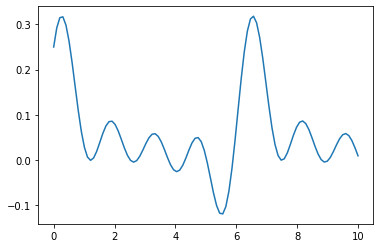

In [3]:
x = torch.tensor(np.linspace(0, 10, 100))
target_y = target_function(x, 5)
plt.plot(x.numpy(), target_y.numpy())

In [4]:
class Model(QuantumCircuit):
    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        self.ansatz1 = AlternateLayerAnsatz(n_qubits, n_layers)
        self.embedding = SingleLayerEncoding(n_qubits)
        self.ansatz2 = AlternateLayerAnsatz(n_qubits, n_layers)
        
        
    def forward(self, x):
        batch_size = len(x)
        state = self.init_state(batch_size)
        
        state = self.ansatz1(state)
        state = self.embedding(state, x)
        state = self.ansatz2(state)
        
        new_state = Z(state, [0], self.n_qubits)
        
        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))
        
        return torch.real(torch.sum(torch.conj(state) * new_state, axis=0))

In [5]:
n_qubits = 5
n_layers = 3

model = Model(n_qubits, n_layers)

In [6]:
with torch.no_grad():
    y = model(x)

In [7]:
model(x[0:10]).shape

torch.Size([10])

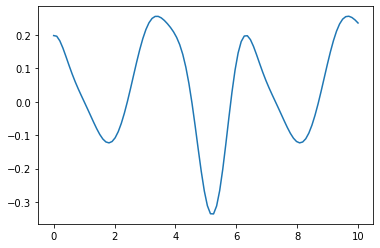

In [8]:
plt.plot(x.numpy(), y.numpy())

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
epochs = 200

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = F.mse_loss(target_y, y_pred)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss {loss}")

Epoch 1 | Loss 7.976638980490219e-05
Epoch 2 | Loss 0.00018516320389538174
Epoch 3 | Loss 0.00015250069418123508
Epoch 4 | Loss 0.0002954347442288451
Epoch 5 | Loss 9.96617571595185e-05
Epoch 6 | Loss 0.00015587379722353136
Epoch 7 | Loss 0.00014239923158366834
Epoch 8 | Loss 0.0001117781615256353
Epoch 9 | Loss 0.00011458096332979135
Epoch 10 | Loss 8.521301757740507e-05
Epoch 11 | Loss 9.186455606689106e-05
Epoch 12 | Loss 0.00011302529934456084
Epoch 13 | Loss 7.959300999009852e-05
Epoch 14 | Loss 5.2588442274184146e-05
Epoch 15 | Loss 6.899284437318874e-05
Epoch 16 | Loss 7.712150554875724e-05
Epoch 17 | Loss 6.734313331522322e-05
Epoch 18 | Loss 6.244483340190226e-05
Epoch 19 | Loss 5.285628239744807e-05
Epoch 20 | Loss 4.327889542059836e-05
Epoch 21 | Loss 5.068718981105365e-05
Epoch 22 | Loss 5.669043898201916e-05
Epoch 23 | Loss 4.6521824954857976e-05
Epoch 24 | Loss 3.854451028245699e-05
Epoch 25 | Loss 3.95755427944772e-05
Epoch 26 | Loss 3.800998614927786e-05
Epoch 27 | Loss

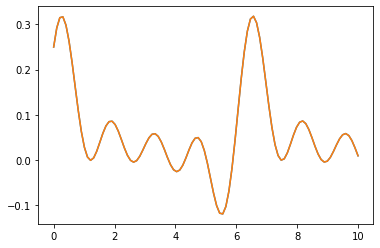

In [13]:
with torch.no_grad():
    y = model(x)

plt.plot(x.numpy(), target_y.numpy())    
plt.plot(x.numpy(), y.numpy())